In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:


# Hämta från databasen
conn = sqlite3.connect("matkassen_data_ny.db")
df_final = pd.read_sql("SELECT * FROM processed_data", conn)


In [3]:
df_final.head()

,leverans_id,prenumeration_id,kund_id,pren_startdatum,paus_från,paus_till,pren_avslutsdatum,kassatyp,kostpreferens,antal_portioner,...,har_avslutat,pris_per_portion,region,stad_namn,sentiment_label,sentiment_score,feat_sentiment_index,feat_sentiment_mismatch,feat_extreme_sentiment,feat_is_negative
0,LEV-2024-000001,PREN-1002,KUND-05001,2024-04-10 00:00:00,NaN,NaN,NaN,klassiskkasse,ingen preferens,4.0,...,0,174.75,10,Storstockholm,None,None,None,0,0,0
1,LEV-2024-000002,PREN-1003,KUND-05002,2024-06-12 00:00:00,NaN,NaN,NaN,familjekasse,ingen preferens,6.0,...,0,153.17,40,Göteborg,None,None,None,0,0,0
2,LEV-2024-000003,PREN-1011,KUND-05010,2024-05-11 00:00:00,NaN,NaN,2024-07-16 00:00:00,vegetariskkasse,okänt,4.0,...,1,177.25,10,Storstockholm,None,None,None,0,0,0
3,LEV-2024-000004,PREN-1017,KUND-05016,2024-05-26 00:00:00,NaN,NaN,NaN,expresskasse,laktosfri,4.0,...,0,172.25,40,Göteborg,None,None,None,0,0,0
4,LEV-2024-000005,PREN-1018,KUND-05017,2024-05-02 00:00:00,NaN,NaN,2024-08-19 00:00:00,klassiskkasse,okänt,2.0,...,1,249.50,21,Malmö,None,None,None,0,0,0


KPI 1: Churn Rate per Kassetyp (%)
 kassatyp
expresskasse       20.454545
familjekasse       10.070922
klassiskkasse      20.454545
vegankasse         37.500000
vegetariskkasse    16.666667
Name: har_avslutat, dtype: float64


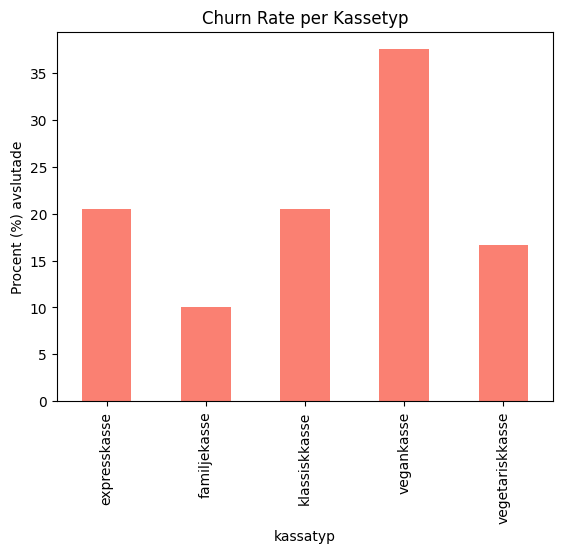

In [10]:
kpi1_churn = df_final.groupby('kassatyp')['har_avslutat'].mean() * 100
print("KPI 1: Churn Rate per Kassetyp (%)\n", kpi1_churn)

kpi1_churn.plot(kind='bar', color='salmon', title='Churn Rate per Kassetyp')
plt.ylabel('Procent (%) avslutade')
plt.show()

KPI 3: Snittpris för aktiva (0) vs avslutade (1)
 har_avslutat
0    189.384558
1    204.146920
Name: pris_per_portion, dtype: float64


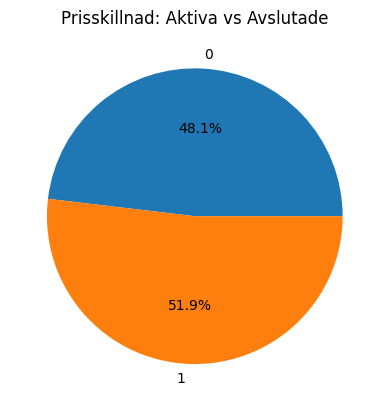

In [12]:
kpi3_price_churn = df_final.groupby('har_avslutat')['pris_per_portion'].mean()
print("KPI 3: Snittpris för aktiva (0) vs avslutade (1)\n", kpi3_price_churn)

kpi3_price_churn.plot(kind='pie', autopct='%1.1f%%', title='Prisskillnad: Aktiva vs Avslutade')
plt.show()

KPI 4: Churn per Stad (%)
 stad_namn
Malmö             20.000000
Storstockholm     17.759146
Övriga Sverige    17.223650
Göteborg          14.733542
Name: har_avslutat, dtype: float64


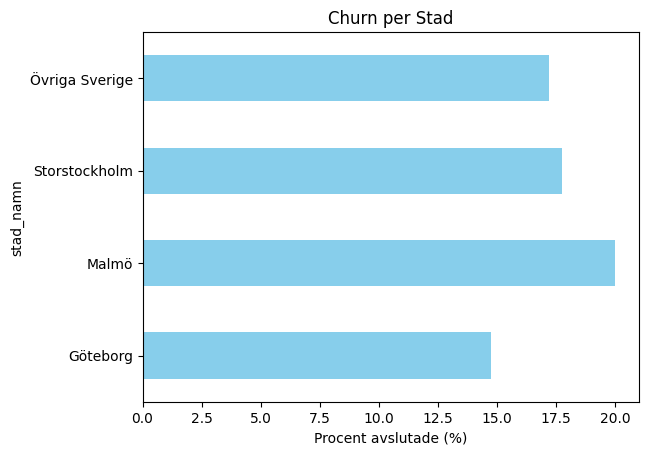

In [16]:
kpi4_region_churn = df_final.groupby('stad_namn')['har_avslutat'].mean() * 100
print("KPI 4: Churn per Stad (%)\n", kpi4_region_churn.sort_values(ascending=False))

kpi4_region_churn.plot(kind='barh', color='skyblue', title='Churn per Stad')
plt.xlabel('Procent avslutade (%)')
plt.show()